In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
pd.options.mode.chained_assignment = None

In [2]:
def ecdf(data):
    """
    Takes a dataset and creates x and y for ECDF plot
    """
    n=len(data)
    x=np.sort(data)
    y=np.arange(1, n+1)/n
    return x,y


In [3]:
def pearson_r(x_data, y_data):
    """
    Takes x and y data arrays
    Returns the pearson r coefficient
    """
    corr_matrix = np.corrcoef(x_data, y_data)
    return corr_matrix[0,1]

In [4]:
def get_least_squares(x, y):
    """
    Takes an x-data array and y-data array
    Returns x and y data for least squares line
    """
    slope, intercept = np.polyfit(x, y, 1)
    ls_x = np.array([0,x.max()])
    ls_y = slope*ls_x + intercept
    return ls_x, ls_y


In [5]:
#import cleaned H1B dataset
#full dataset can be found: https://www.kaggle.com/nsharan/h-1b-visa/data
#A description of cleanup can be found: https://github.com/Liptoni/Springboard/blob/master/H1B_Capstone/H1B_Data_Wrangling.docx
hb_data = pd.read_csv('h1b_clean.csv', index_col='CASE_NUMBER')

#need to create these in order to join with census data
hb_data['lat_round'] = hb_data['lat'].apply(lambda x: round(x, 4))
hb_data['lon_round'] = hb_data['lon'].apply(lambda x: round(x, 4))

C:\Users\Ian\AppData\Roaming\Python\Python36\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
#import census data
census_cols = ['ID1', 'ID', 'lat', 'lon', 'block_fips', 'block_pop_2015', 'county_fips', 'county_name', 'state_code', 'state_fips', 'state_name', 'county_pop', 'GEONAME']
census_data = pd.read_csv('county_pop.csv', header=0, names=census_cols)
census_data['lat_round'] = census_data['lat'].apply(lambda x: round(x, 4))
census_data['lon_round'] = census_data['lon'].apply(lambda x: round(x, 4))
census_data = census_data[['ID', 'lat_round', 'lon_round', 'block_fips', 'block_pop_2015', 'county_fips', 'county_name', 'county_pop', 'state_code', 'state_fips', 'state_name']]


## Wages for Certified and Denied Applications

Set up a hypothesis test to determine if the average wage for applications that were denied is the same as applications that were certified:

$H_0$: certified = denied

$H_A$: certified != denied

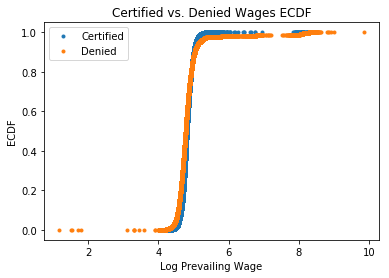

In [7]:
#filter data to split between certified and denied applications. Remove records where wage is 0
cert_filter = (hb_data.CERTIFIED == 'certified') & (hb_data.PREVAILING_WAGE!= 0)
den_filter = (hb_data.CERTIFIED == 'denied') & (hb_data.PREVAILING_WAGE!= 0)

cert_wage = hb_data[cert_filter]['LOG_WAGE'].dropna()
den_wage = hb_data[den_filter]['LOG_WAGE'].dropna()

#create ECDF to visually compare these two datsets
cert_x, cert_y = ecdf(cert_wage)
den_x, den_y = ecdf(den_wage)

plt.plot(cert_x, cert_y, marker='.', linestyle='none')
plt.plot(den_x, den_y, marker='.', linestyle='none')

plt.xlabel('Log Prevailing Wage')
plt.ylabel("ECDF")
plt.title("Certified vs. Denied Wages ECDF")
plt.legend(['Certified', 'Denied'])
plt.show()

In [8]:
print('Certified Mean =', cert_wage.mean())
print('Denied Mean =', den_wage.mean())

Certified Mean = 4.823906255172546
Denied Mean = 4.840176933782409


In [9]:
#perform t-test to compare means of wages for certified and denied samples 

t, p = stats.ttest_ind(cert_wage, den_wage, equal_var=False)
print('p-value:',p)

p-value: 1.6930074841975466e-26


Based on this p-value we would reject the null hypothesis that the average wage for certified and denied applications are the same.

## Wages for Full-time and Part-time Applications

Set up a hypothesis test to determine if the average wage for applications for full-time positions is the same as the average wage of applications for part-time positions:

$H_0$: full-time = part-time

$H_A$: full-time != part-time

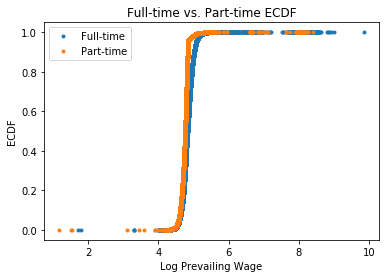

In [10]:
#filter to split data into full-time and part-time position applications. Remove records with a 0 wage
ft_filter = (hb_data.PREVAILING_WAGE != 0) & (hb_data.FULL_TIME_POSITION == 'Y')
pt_filter = (hb_data.PREVAILING_WAGE != 0) & (hb_data.FULL_TIME_POSITION == 'N')

ft_wage = hb_data[ft_filter]['LOG_WAGE'].dropna()
pt_wage = hb_data[pt_filter]['LOG_WAGE'].dropna()

#create ECDF
ft_x, ft_y = ecdf(ft_wage)
pt_x, pt_y = ecdf(pt_wage)

plt.plot(ft_x, ft_y, marker='.', linestyle='none')
plt.plot(pt_x, pt_y, marker='.', linestyle='none')

plt.xlabel('Log Prevailing Wage')
plt.ylabel("ECDF")
plt.title("Full-time vs. Part-time ECDF")
plt.legend(['Full-time', 'Part-time'])
plt.show()

In [11]:
print('Full-time Mean =', ft_wage.mean())
print('Part-time Mean =', pt_wage.mean())

Full-time Mean = 4.8370548707842795
Part-time Mean = 4.747723891626538


In [12]:
t,p=stats.ttest_ind(ft_wage, pt_wage, equal_var=False)
print('p-value:', p)

p-value: 0.0


With such a small p-value, we would reject the null hypothesis that wages for full-time and part-time positions are the same.

## County Population of Certified and Denied Applications

Here I set up a hypothesis test to determine if there is a difference in the population of counties for applications that were certified or denied. The county corresponds to the block of the potential employer's location.

$H_0$: Certified = Denied

$H_A$: Certified != Denied

In [13]:
#merge census data with h1b data
hb_census = hb_data.merge(census_data, how='left', left_on=['lat_round', 'lon_round'], right_on=['lat_round', 'lon_round'])
hb_census = hb_census[['FULL_TIME_POSITION', 'PREVAILING_WAGE', 'LOG_WAGE', 'CERTIFIED', 'county_pop']]

print(hb_census.head())

  FULL_TIME_POSITION  PREVAILING_WAGE  LOG_WAGE  CERTIFIED  county_pop
0                  N          36067.0  4.557110  certified    364709.0
1                  Y         242674.0  5.385023  certified    939585.0
2                  Y         193066.0  5.285706  certified    677983.0
3                  Y         220314.0  5.343042  certified    693060.0
4                  Y         225000.0  5.352183  certified   2712945.0


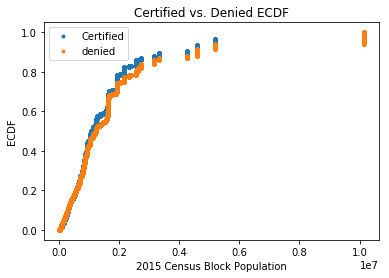

In [14]:
#separate certified and denied into two datasets with corresponding county populations
cert_filter = (hb_census.CERTIFIED=='certified')&(hb_census.county_pop.notnull())
den_filter = (hb_census.CERTIFIED=='denied')&(hb_census.county_pop.notnull())
cert_pop = hb_census[cert_filter]['county_pop']
den_pop = hb_census[den_filter]['county_pop']

#create ECDF plots
cert_x, cert_y = ecdf(cert_pop)
den_x, den_y = ecdf(den_pop)

plt.plot(cert_x, cert_y, marker='.', linestyle='none')
plt.plot(den_x, den_y, marker='.', linestyle='none')

plt.xlabel('2015 Census Block Population')
plt.ylabel("ECDF")
plt.title("Certified vs. Denied ECDF")
plt.legend(['Certified', 'denied'])
plt.show()

In [15]:
#show mean populations for the two samples
print('Certified Mean =', round(cert_pop.mean(),0))
print('Denied Mean =', round(den_pop.mean(),0))

Certified Mean = 1720650.0
Denied Mean = 1993234.0


In [16]:
#run t-test comparing means of two samples
t,p=stats.ttest_ind(cert_pop, den_pop, equal_var=False)
print('p-value:', p)

p-value: 3.424243166084512e-240


Based on the results of the t-test I would reject the null hypothesis that the county population for applications that were certified and denied are the same.